In [3]:
import pandas as pd
from statsmodels.stats.outliers_influence import variance_inflation_factor
import statsmodels.api as sm

# File info
file_path = r"C:\Users\PCAdmin\OneDrive - Douglas College\Documents\4th Semester\2_Business_Statistics_II\Python\DataScratch.xlsx"
sheet_name = "15D_MultiCol"

# Load dataset
df = pd.read_excel(file_path, sheet_name=sheet_name)
print("Dataset:")
print(df)

# Automatically select all x columns (e.g., x1, x2, ..., xn)
X = df[[col for col in df.columns if col.startswith('x')]]

# Add constant for intercept
X = sm.add_constant(X)

# Calculate VIF
vif_data = pd.DataFrame()
vif_data['Variable'] = X.columns
vif_data['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

# Tag multicollinearity if VIF > 5
vif_data['Multicollinearity'] = vif_data['VIF'].apply(lambda v: "Yes" if v > 5 else "No")

print("\nVariance Inflation Factors with Tags:")
print(vif_data)


Dataset:
    y  x1  x2  x3
0  33  40  27   6
1  38  42  20  15
2  40  42  23   9
3  39  45  20  12
4  47  44  12  18
5  51  48  18  17
6  53  53  17  23
7  59  57  14  20
8  51  76  18  27
9  64  58  15  29

Variance Inflation Factors with Tags:
  Variable        VIF Multicollinearity
0    const  90.200263               Yes
1       x1   3.820000                No
2       x2   2.747567                No
3       x3   6.810265               Yes


Best model uses 3 feature(s): ['x1', 'x3', 'x4']

Coefficients:
const    35.851213
x1        0.353575
x3        0.494269
x4       -0.688661
dtype: float64


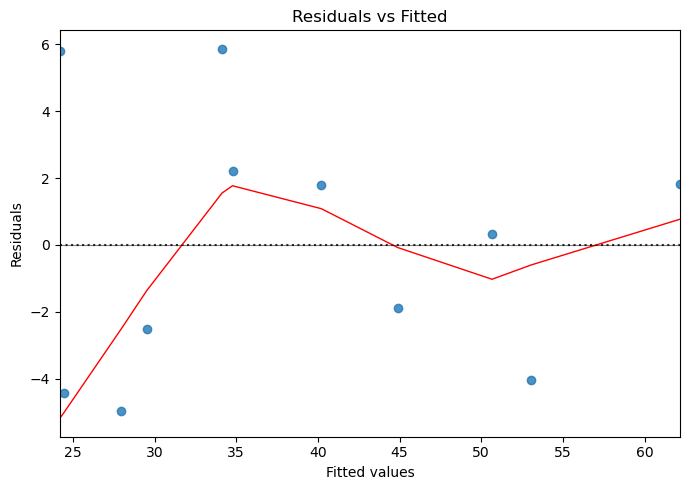

Global Breusch–Pagan p-value: 0.2830
→ No evidence of heteroscedasticity

=== Constant variance check per predictor (BP tests) ===
x1: p-value = 0.1169
x2: p-value = 0.0397
x3: p-value = 0.9974
x4: p-value = 0.0733


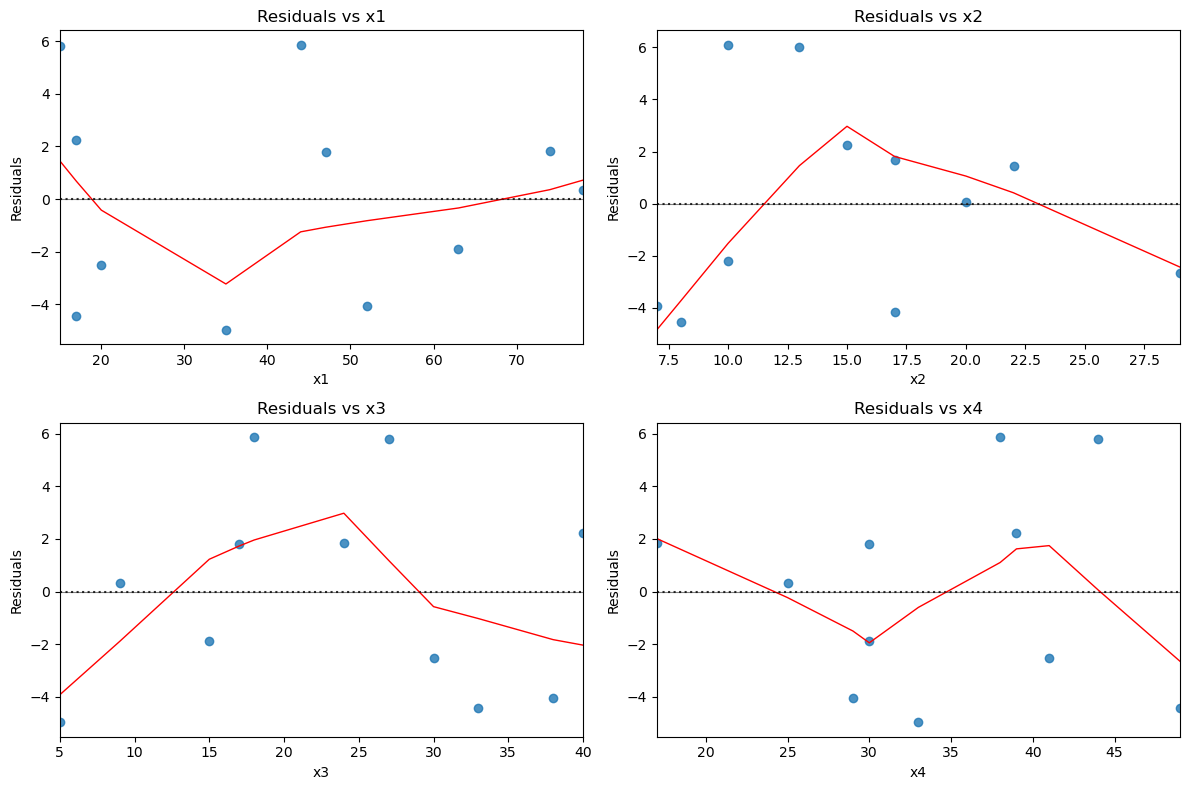


=== Constant variance check per predictor (Breusch–Pagan, single-explanatory) ===
x1: p-value = 0.1169
x2: p-value = 0.0397
x3: p-value = 0.9974
x4: p-value = 0.0733

Conclusion: Constant variance assumption is NOT MET for these predictors:
 - x2 (p < 0.05)
Predictors without evidence of heteroscedasticity:
 - x1 (p ≥ 0.05)
 - x3 (p ≥ 0.05)
 - x4 (p ≥ 0.05)


In [9]:
import pandas as pd
import itertools
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.stats.diagnostic import het_breuschpagan
import numpy as np

# ===================== Load data =====================
def load_data(file_path, sheet_name):
    return pd.read_excel(file_path, sheet_name=sheet_name)

# ===================== Best subset selection =====================
def best_subset_selection(X, y):
    """
    Returns a list of dicts: one entry per subset size k with the best-RSS model at that k.
    Each dict has: num_features, features, model, rss
    """
    results = []
    for k in range(1, len(X.columns) + 1):
        best_rss, best_model, best_features = float('inf'), None, None
        for combo in itertools.combinations(X.columns, k):
            Xk = sm.add_constant(X[list(combo)], has_constant='add')
            model = sm.OLS(y, Xk).fit()
            rss = ((model.fittedvalues - y) ** 2).sum()
            if rss < best_rss:
                best_rss, best_model, best_features = rss, model, combo
        results.append({
            'num_features': k,
            'features': best_features,
            'model': best_model,
            'rss': best_rss
        })
    return results

# ===================== Residual plots & constant-variance tests =====================
def plot_residuals_vs(X, residuals, title_prefix="Residuals vs"):
    """
    Make residual plots vs each predictor with LOWESS. Returns nothing (just plots).
    """
    p = len(X.columns)
    ncols = min(2, p)
    nrows = int(np.ceil(p / ncols))
    fig, axes = plt.subplots(nrows, ncols, figsize=(6*ncols, 4*nrows))
    axes = np.array(axes).reshape(-1)  # flatten for easy indexing

    for i, col in enumerate(X.columns):
        ax = axes[i]
        sns.residplot(x=X[col], y=residuals, lowess=True,
                      line_kws={'color': 'red', 'lw': 1}, ax=ax)
        ax.set_xlabel(col)
        ax.set_ylabel("Residuals")
        ax.set_title(f"{title_prefix} {col}")
        ax.axhline(0, color='k', lw=0.8, alpha=0.5)

    # hide any unused axes
    for j in range(i+1, len(axes)):
        axes[j].set_visible(False)
    plt.tight_layout()
    plt.show()

def assess_constant_variance_per_predictor(residuals, X_all):
    """
    For each predictor x1..x4, run a one-variable Breusch–Pagan test:
      H0: constant variance; HA: variance related to that predictor.
    Returns dict: {predictor: p_value}
    """
    pvals = {}
    for col in X_all.columns:
        # BP test needs residuals and exog that produced residuals; we use the predictor alone (plus const)
        exog = sm.add_constant(X_all[[col]], has_constant='add')
        _, pval, _, _ = het_breuschpagan(residuals, exog)
        pvals[col] = pval
    return pvals

def constant_variance_report(pvals_by_x, alpha=0.05):
    """
    Return a dict with:
      - 'flagged': list of predictors with p < alpha (evidence of heteroscedasticity)
      - 'ok': list of predictors with p >= alpha
      - 'met': True if none flagged (constant variance met), else False
    """
    flagged = [k for k, pv in pvals_by_x.items() if pv < alpha]
    ok = [k for k, pv in pvals_by_x.items() if pv >= alpha]
    return {
        'flagged': sorted(flagged),
        'ok': sorted(ok),
        'met': len(flagged) == 0
    }


# ===================== Residual analysis (fitted & global BP) =====================
def residual_analysis_global(model, X_used, y):
    Xc = sm.add_constant(X_used, has_constant='add')
    fitted = model.predict(Xc)
    residuals = y - fitted

    # Residuals vs Fitted
    plt.figure(figsize=(7, 5))
    sns.residplot(x=fitted, y=residuals, lowess=True, line_kws={'color': 'red', 'lw': 1})
    plt.axhline(0, color='k', lw=0.8, alpha=0.5)
    plt.xlabel("Fitted values")
    plt.ylabel("Residuals")
    plt.title("Residuals vs Fitted")
    plt.tight_layout()
    plt.show()

    # Global Breusch–Pagan using all regressors in the chosen model
    _, p_bp, _, _ = het_breuschpagan(residuals, Xc)
    print(f"Global Breusch–Pagan p-value: {p_bp:.4f}")
    print("→ Evidence of heteroscedasticity" if p_bp < 0.05 else "→ No evidence of heteroscedasticity")

    return residuals, fitted

# ===================== Main / Usage =====================
file_path = r"C:\Users\PCAdmin\OneDrive - Douglas College\Documents\4th Semester\2_Business_Statistics_II\Python\DataScratch.xlsx"
sheet_name = "15D_BestSubSet"

df = load_data(file_path, sheet_name)
# Predictors are all columns starting with 'x' (x1..x4) and response 'y'
X_all = df[[c for c in df.columns if c.startswith('x')]]
y = df['y']

# Best subset across sizes (pick best by Adjusted R^2)
best_models = best_subset_selection(X_all, y)
best_model_info = max(best_models, key=lambda r: r['model'].rsquared_adj)
best_model = best_model_info['model']
best_features = list(best_model_info['features'])

print(f"Best model uses {len(best_features)} feature(s): {best_features}")
print("\nCoefficients:")
print(best_model.params)

# Global residual analysis for the chosen model
residuals, fitted = residual_analysis_global(best_model, X_all[best_features], y)

# ---- PART (b): Residual plots vs EACH predictor & MCQ decision A–E ----
print("\n=== Constant variance check per predictor (BP tests) ===")
pvals_by_x = assess_constant_variance_per_predictor(residuals, X_all)
for col, pv in pvals_by_x.items():
    print(f"{col}: p-value = {pv:.4f}")

# Plots: residuals vs each x1..x4 (LOWESS lines)
plot_residuals_vs(X_all, residuals, title_prefix="Residuals vs")

# Map test outcomes to the multiple-choice answers
print("\n=== Constant variance check per predictor (Breusch–Pagan, single-explanatory) ===")
pvals_by_x = assess_constant_variance_per_predictor(residuals, X_all)
for col, pv in sorted(pvals_by_x.items()):
    print(f"{col}: p-value = {pv:.4f}")

report = constant_variance_report(pvals_by_x, alpha=0.05)

if report['met']:
    print("\nConclusion: Constant variance assumption is MET (no predictors showed a pattern).")
else:
    print("\nConclusion: Constant variance assumption is NOT MET for these predictors:")
    for col in report['flagged']:
        print(f" - {col} (p < 0.05)")
    if report['ok']:
        print("Predictors without evidence of heteroscedasticity:")
        for col in report['ok']:
            print(f" - {col} (p ≥ 0.05)")